Upgrade pip installer to match python version

In [2]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Installing all necessary packages


In [3]:
%pip install sklearn
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install nflfastpy
%pip install statsmodels

%pip install nfl_data_py
%pip install seaborn
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [2]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier

In [3]:
pbp = nfl.import_pbp_data([2022, 2023])

2022 done.
2023 done.
Downcasting floats.


In [5]:
pbp.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,None,None,None,...,,,0.0,0.0,NaN,NaN,NaN,None,None,None
1,43.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036157;00-0035202;00-0037984;00-0029597;00...,00-0035537;00-0032134;00-0034419;00-0036500;00...,11.0,11.0,NaN,NaN,NaN,None,None,None
2,68.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11.0,11.0,NaN,NaN,NaN,None,None,None
3,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0032234;00-0036979;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11.0,11.0,0.56,3.07,1.0,ANGLE,ZONE_COVERAGE,COVER_2
4,115.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11.0,11.0,NaN,NaN,NaN,None,None,None


In [6]:
print(pbp.shape)
pbp_clean = pbp[(pbp['pass'] == 1) & (pbp['play_type'] != "no_play")]
print(pbp_clean.shape)

(99248, 390)
(42907, 390)


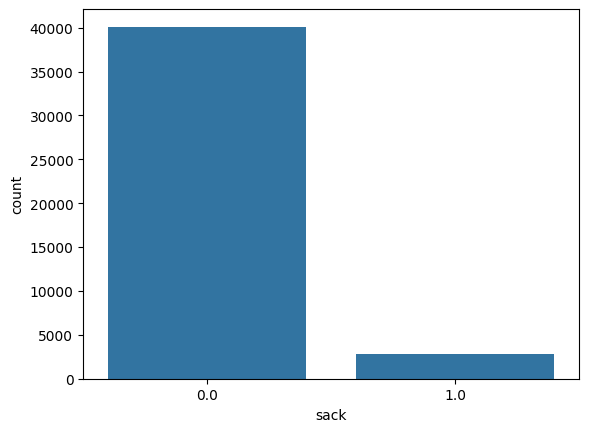

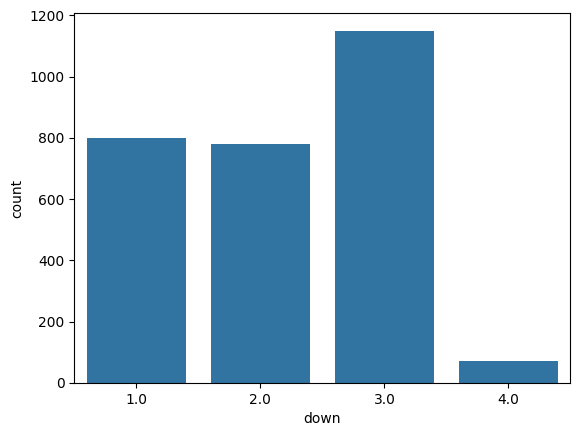

In [7]:
sns.countplot(x=pbp_clean["sack"])
plt.show()
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["down"])
plt.show()

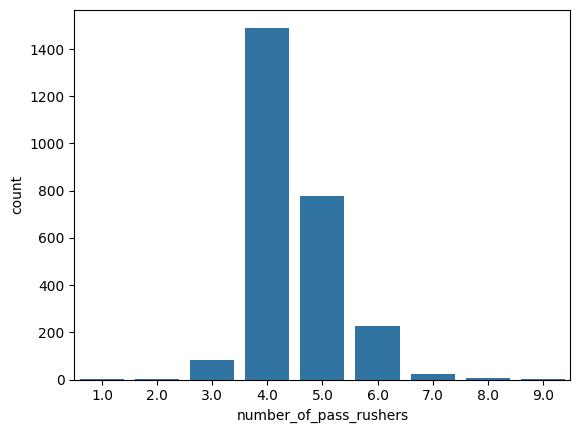

In [12]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["number_of_pass_rushers"])
plt.show()

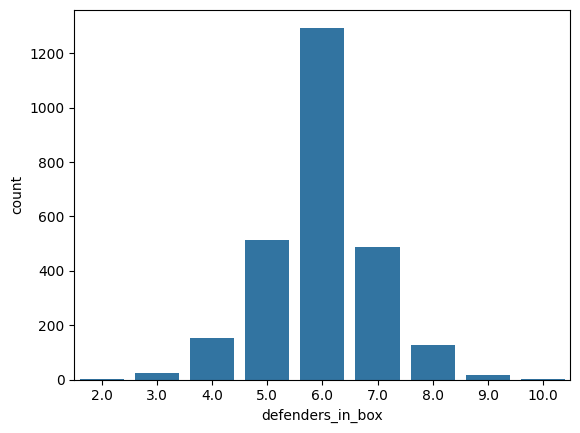

In [13]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["defenders_in_box"])
plt.show()

In [14]:
pbp_clean.loc[:, 'obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1,0)

/var/folders/n6/fctsvhx51zv2t2mnhw79_mxh0000gn/T/ipykernel_13328/1064845038.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp_clean.loc[:, 'obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1,0)
/var/folders/n6/fctsvhx51zv2t2mnhw79_mxh0000gn/T/ipykernel_13328/1064845038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_clean.loc[:, 'obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1,0)


In [15]:
pre_df = pbp_clean[['game_id', 'play_id', 'season', 'name', 'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining',
                    'defenders_in_box', 'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack']]
df = pre_df.dropna()
df.isna().sum()

game_id                   0
play_id                   0
season                    0
name                      0
down                      0
ydstogo                   0
yardline_100              0
game_seconds_remaining    0
defenders_in_box          0
number_of_pass_rushers    0
xpass                     0
obvious_pass              0
sack                      0
dtype: int64

In [16]:
df.head()

,game_id,play_id,season,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack
3,2022_01_BAL_NYJ,89.0,2022,J.Flacco,1.0,10.0,59.0,3569.0,6.0,4.0,0.389904,0,0.0
5,2022_01_BAL_NYJ,136.0,2022,J.Flacco,3.0,5.0,54.0,3541.0,7.0,4.0,0.963242,0,0.0
7,2022_01_BAL_NYJ,202.0,2022,L.Jackson,1.0,10.0,72.0,3522.0,7.0,4.0,0.479318,0,0.0
8,2022_01_BAL_NYJ,230.0,2022,L.Jackson,2.0,6.0,68.0,3501.0,6.0,3.0,0.608057,0,0.0
11,2022_01_BAL_NYJ,301.0,2022,L.Jackson,2.0,10.0,60.0,3379.0,5.0,4.0,0.565180,0,0.0


In [17]:
df.loc[:, 'down'] = df['down'].astype('category')
df_no_ids = df.drop(columns = ['game_id', 'play_id', 'name', 'season'])
df_no_ids = pd.get_dummies(df_no_ids, columns = ['down'])

In [18]:
df_no_ids.columns

Index(['ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
       'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack', 'down_1.0',
       'down_2.0', 'down_3.0', 'down_4.0'],
      dtype='object')

In [19]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(df_no_ids, df_no_ids['sack']):
    strat_train_set = df_no_ids.iloc[train_index]
    strat_test_set = df_no_ids.iloc[test_index]

X_train = strat_train_set.drop(columns = ['sack'])
Y_train = strat_train_set['sack']
X_test = strat_test_set.drop(columns = ['sack'])
Y_test = strat_test_set['sack']

In [20]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train, Y_train)

LR_pred = pd.DataFrame(LR.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, LR_pred))


Brier Score:  0.06085825109000016


In [21]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

RF_pred = pd.DataFrame(RF.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, RF_pred))

Brier Score:  0.0654644052554288


In [10]:
XGB = XGBClassifier(objective="binary:logistic", random_state=42)
XGB.fit(X_train, Y_train)

XGB_pred = pd.DataFrame(XGB.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, XGB_pred))

NameError: name 'X_train' is not defined

In [9]:
sorted_idx = XGB.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], XGB.feature_importances_[sorted_idx])
plt.title("XGBClassifier Feature Importance")
plt.show()

NameError: name 'XGB' is not defined

In [8]:
data_for_prediction = df_no_ids.drop('sack', axis = 1)

XGB_predictions = pd.DataFrame(XGB.predict_proba(data_for_prediction), columns = ['no_sack_probability', 'sack_probability'])[['sack_probability']]

original_data_with_predictions = df.reset_index().drop(columns = ['index'])
original_data_with_predictions['sack_probability'] = XGB_predictions

original_data_with_predictions['sacks_over_under'] = original_data_with_predictions['sack'] - original_data_with_predictions['sack_probability']

summary_2023 = original_data_with_predictions[(original_data_with_predictions['season'] == 2023)].groupby('name').agg({'sack': 'sum', 'sack_probability': 'sum', 'sacks_over_under': 'sum'}).reset_index().sort_values('sacks_over_under', ascending = True)

print(summary_2023)

NameError: name 'df_no_ids' is not defined

In [40]:
summary_2023 = original_data_with_predictions[(original_data_with_predictions['season'] == 2023)].groupby('name').agg({'sack': 'sum', 'sack_probability': 'sum', 'sacks_over_under': 'sum'}).reset_index().sort_values('sack_probability', ascending = False)

print(summary_2023)

            name  sack  sack_probability  sacks_over_under
81      S.Howell  59.0         41.521465         17.478533
10       B.Young  48.0         38.582176          9.417823
90    T.Lawrence  32.0         36.697262         -4.697262
29    D.Prescott  35.0         36.609634         -1.609633
7     B.Mayfield  33.0         35.513580         -2.513578
..           ...   ...               ...               ...
74    N.Peterman   1.0          0.014446          0.985554
32  D.Singletary   0.0          0.008582         -0.008582
21    Co.Heyward   0.0          0.007622         -0.007622
35       D.Wicks   0.0          0.005708         -0.005708
4      A.Rodgers   1.0          0.005639          0.994361

[96 rows x 4 columns]


In [37]:
summary_2023 = original_data_with_predictions[(original_data_with_predictions['season'] == 2023)].groupby('name').agg({'sack': 'sum', 'sack_probability': 'sum', 'sacks_over_under': 'sum'}).reset_index().sort_values('sack_probability', ascending = False)

summary_2023 = summary_2023.head(20)

print(summary_2023)

          name  sack  sack_probability  sacks_over_under
81    S.Howell  59.0         41.521465         17.478533
10     B.Young  48.0         38.582176          9.417823
90  T.Lawrence  32.0         36.697262         -4.697262
29  D.Prescott  35.0         36.609634         -1.609633
7   B.Mayfield  33.0         35.513580         -2.513578
51   J.Herbert  29.0         35.429489         -6.429490
54      J.Love  28.0         35.274464         -7.274465
52     J.Hurts  34.0         34.806885         -0.806884
68  M.Stafford  25.0         33.424286         -8.424285
95    Z.Wilson  46.0         33.182068         12.817933
79    R.Wilson  38.0         33.151680          4.848320
49      J.Goff  26.0         32.838104         -6.838104
40     J.Allen  19.0         32.675007        -13.675007
64   L.Jackson  36.0         31.342834          4.657165
45     J.Dobbs  30.0         31.304045         -1.304044
76   P.Mahomes  22.0         30.659344         -8.659344
18    C.Stroud  35.0         30

In [4]:
summary_2023 = original_data_with_predictions[(original_data_with_predictions['season'] == 2022)].groupby('name').agg({'sack': 'sum', 'sack_probability': 'sum', 'sacks_over_under': 'sum'}).reset_index().sort_values('sack_probability', ascending = False)

summary_2023 = summary_2023.head(20)

print(summary_2023)

NameError: name 'original_data_with_predictions' is not defined